## Primary Imports

In [86]:
import cv2
import random
import xml.etree.ElementTree as et
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from PIL import Image
from skimage import io
import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Connecting to drive to later use the data folder

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Finding the labels

In [88]:
import xml.etree.ElementTree as et

xml_file_path = "/content/drive/MyDrive/cheetah_train/*.xml"
xml_files = sorted(glob.glob(xml_file_path), key=lambda x: x.split('.')[0])

unique_labels = set()

for file in xml_files:
    info = et.parse(file)
    root = info.getroot()
    obj = root.find('object')

    if obj is not None:
        label_obj = obj.find('name').text
        unique_labels.add(label_obj)

#finding unique labels of data
for label in unique_labels:
    print(label)



human
cheetah


## Defining inputs and outputs, aka the RGb representation of jpg images and label along with bbox coordinates of xml files

In [89]:
xml_file_path = "/content/drive/MyDrive/cheetah_train/*.xml"
xml_files = sorted(glob.glob(xml_file_path), key=lambda x: x.split('.')[0])

output_values = []
for file in xml_files:
    label = 0
    info = et.parse(file)
    root = info.getroot()
    obj = root.find('object')

    label_obj = obj.find('name').text
    if 'cheetah' in label_obj:
        label = 1
    elif 'human' in label_obj:
        label = 2


    bounding_box_obj = obj.find('bndbox')
    xmin = bounding_box_obj.find('xmin').text
    ymin = bounding_box_obj.find('ymin').text
    xmax = bounding_box_obj.find('xmax').text
    ymax = bounding_box_obj.find('ymax').text

    output_values.append([int(label), int(xmin), int(ymin), int(xmax), int(ymax)])

In [90]:
input_image_file_path = "/content/drive/MyDrive/cheetah_train/*.jpg"
input_images = sorted(glob.glob(input_image_file_path), key=lambda x: x.split('.')[0])

input_values = []
for image in input_images:
    img = cv2.imread(image, cv2.COLOR_BGR2RGB)
    input_values.append(img)

## See an example of label and bboxdrawn on a random image below


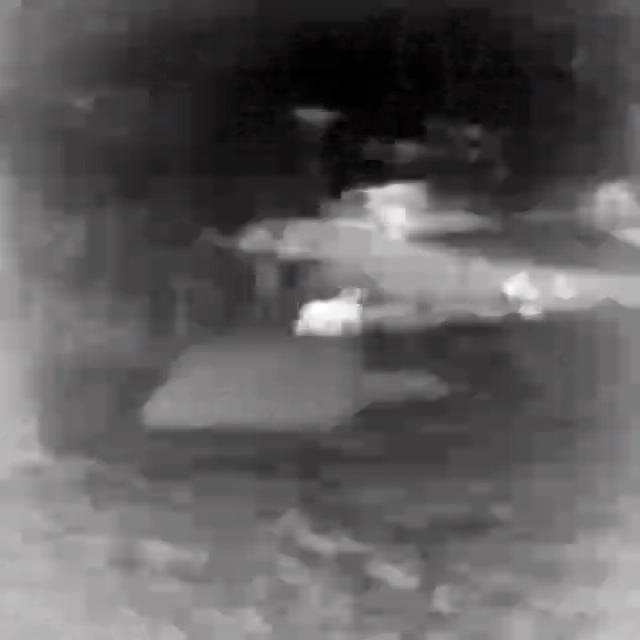

In [91]:
num = random.randint(0,20)
fig = px.imshow(input_values[num])
fig.add_shape(type='rect', x0=output_values[num][1], y0=output_values[num][2], x1=output_values[num][3], y1=output_values[num][4], line_color='violet')

## Preprocessing and splitting the data into train and test

In [92]:
input_values = np.array(input_values, dtype=np.float32)
output_values = np.array(output_values, dtype=np.float32)

In [93]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
input_values = preprocess_input(input_values)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(input_values,output_values, test_size=0.2)

In [95]:
train_label = y_train[:,0:1]
test_label = y_test[:,0:1]
train_bbox = y_train[:,1:]
test_bbox = y_test[:,1:]

print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(f"Train box shape: {train_bbox.shape}")
print(f"Test box shape: {test_bbox.shape}")

Train label shape: (69, 1)
Test label shape: (18, 1)
Train box shape: (69, 4)
Test box shape: (18, 4)


In [96]:
#binary representations
train_label = tf.keras.utils.to_categorical(train_label)
test_label = tf.keras.utils.to_categorical(test_label)

## Defining a ResNet50 model, and adding few DNN layers on top of the output of ResNet50

In [97]:
resnet_model = ResNet50(weights='imagenet', include_top=False,input_shape=(640, 640, 3))

for layer in resnet_model.layers:
        layer.trainable = False

In [98]:
#adding DNN over ResNet50
dl1 = Flatten()(resnet_model.output)
dol1 = Dropout(0.3)(dl1)

dl2 = Dense(52, activation='relu')(dol1)
dol2 = Dropout(0.3)(dl2)

dl3 = Dense(16, activation='relu')(dol2)
dol3 = Dropout(0.3)(dl3)

dl4 = Dense(28, activation='relu')(dol3)

label_output = Dense(3, activation='softmax', name='classification_task')(dl2)
bbox_output = Dense(4, name="regression_task")(dl4)

model = Model(inputs = [resnet_model.input], outputs=[label_output, bbox_output])

## See the model summary and structure below

In [99]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 646, 646, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 320, 320, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

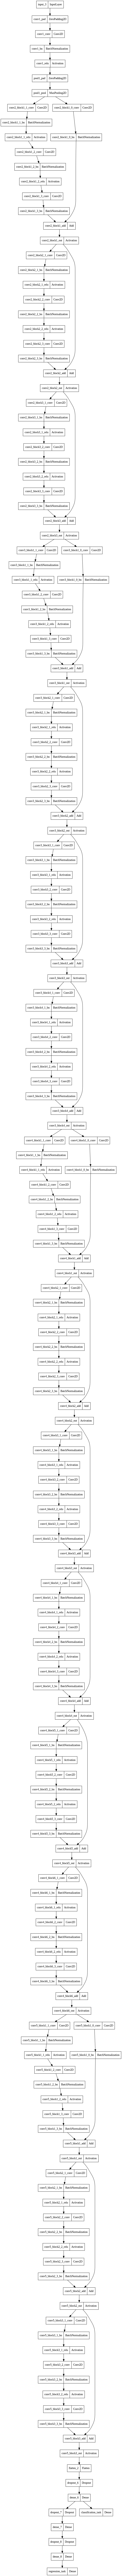

In [116]:
# #structure of the model
tf.keras.utils.plot_model(model)

## Setting model checkpoints for early stopping and saving the model in desired directory

In [101]:
model_checkpoint_cb = ModelCheckpoint('/content/drive/MyDrive/cheetah_train/resnet_model.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)

## Compiling and fitting the model by keeping track of history

In [102]:
model.compile(optimizer=Adam(learning_rate=1e-4),
             loss={'classification_task': 'categorical_crossentropy',
                  'regression_task':'mse'},
             metrics = {
                'classification_task':'accuracy',
                'regression_task':'mse'
             })

In [103]:
history = model.fit(X_train, [train_label, train_bbox], epochs=20, validation_data=(X_test, [test_label, test_bbox]),
                    callbacks=[model_checkpoint_cb, early_stopping_cb])

Epoch 1/20
3/3 [==============================] - 17s 6s/step - loss: 119787.2734 - classification_task_loss: 5.5262 - regression_task_loss: 119781.7500 - classification_task_accuracy: 0.1014 - regression_task_mse: 119781.7500 - val_loss: 114817.3438 - val_classification_task_loss: 16.4967 - val_regression_task_loss: 114800.8438 - val_classification_task_accuracy: 0.8333 - val_regression_task_mse: 114800.8438
Epoch 2/20
3/3 [==============================] - 9s 4s/step - loss: 101055.6484 - classification_task_loss: 3.3887 - regression_task_loss: 101052.2656 - classification_task_accuracy: 0.7971 - regression_task_mse: 101052.2656 - val_loss: 99829.5859 - val_classification_task_loss: 26.9481 - val_regression_task_loss: 99802.6406 - val_classification_task_accuracy: 0.8889 - val_regression_task_mse: 99802.6406
Epoch 3/20
3/3 [==============================] - 6s 3s/step - loss: 92444.3359 - classification_task_loss: 3.3874 - regression_task_loss: 92440.9531 - classification_task_accura

In [104]:
results = history.history

## Below you can see few plots about how the losses and accuracy chaanged from epoch to epoch

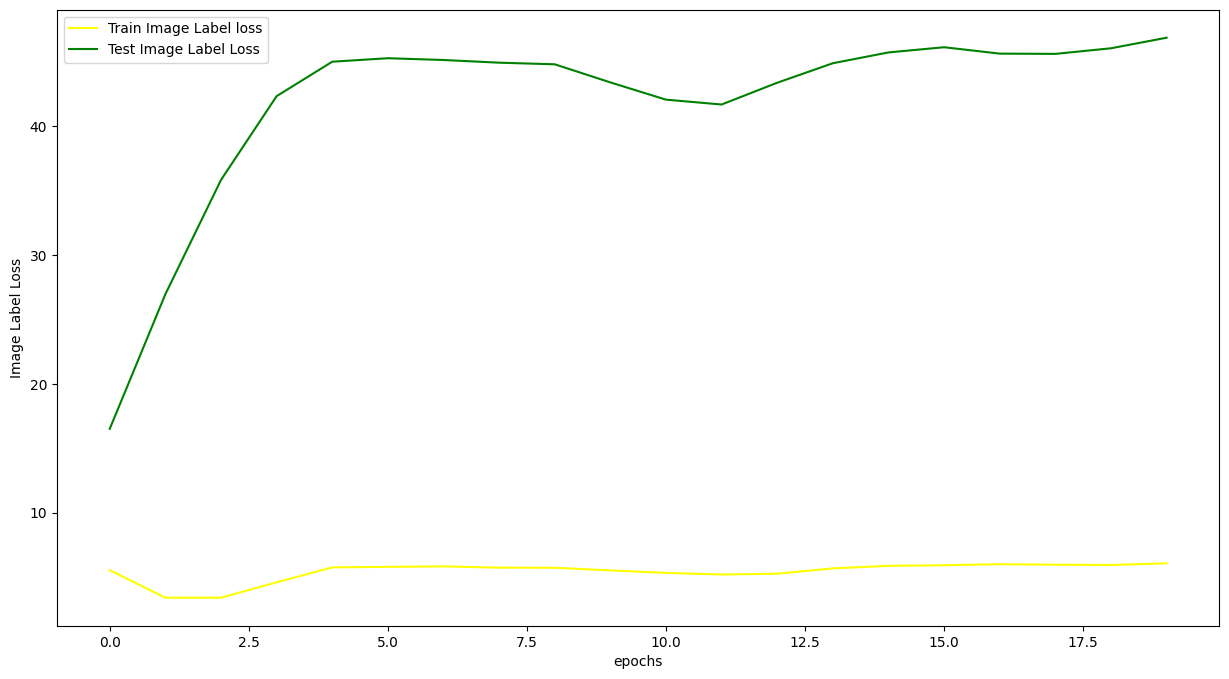

In [105]:
plt.figure(figsize=(15,8))
plt.plot(results['classification_task_loss'],color='yellow',label='Train Image Label loss')
plt.plot(results['val_classification_task_loss'],color='green',label='Test Image Label Loss')
plt.xlabel('epochs')
plt.ylabel('Image Label Loss')
plt.legend()
plt.show()

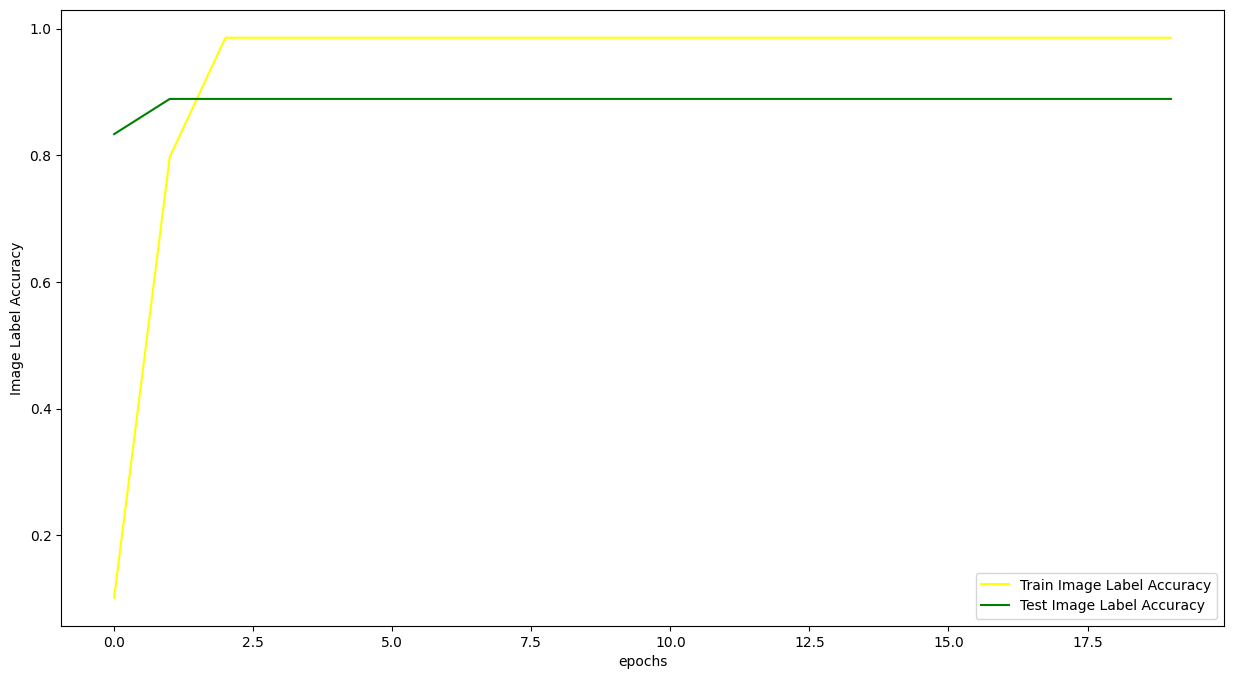

In [106]:
plt.figure(figsize=(15,8))
plt.plot(results['classification_task_accuracy'],color='yellow',label='Train Image Label Accuracy')
plt.plot(results['val_classification_task_accuracy'],color='green',label='Test Image Label Accuracy')
plt.xlabel('epochs')
plt.ylabel('Image Label Accuracy')
plt.legend()
plt.show()

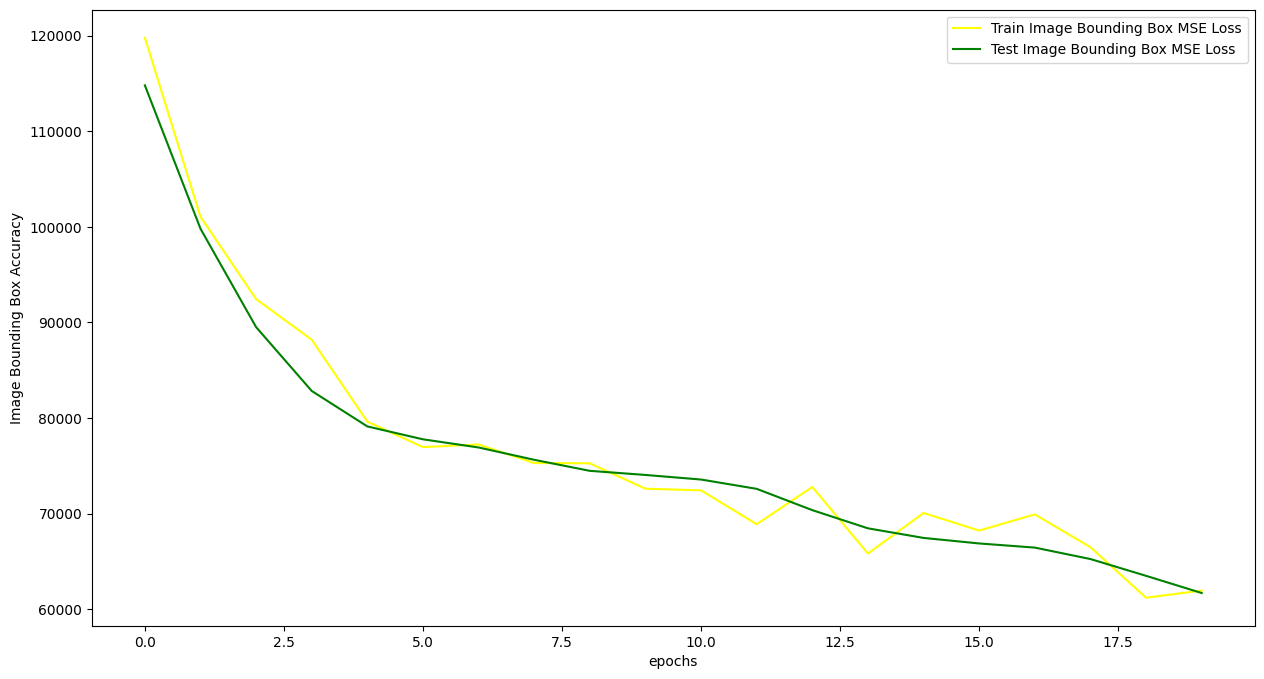

In [107]:
plt.figure(figsize=(15,8))
plt.plot(results['regression_task_loss'],color='yellow',label='Train Image Bounding Box MSE Loss')
plt.plot(results['val_regression_task_loss'],color='green',label='Test Image Bounding Box MSE Loss')
plt.xlabel('epochs')
plt.ylabel('Image Bounding Box Accuracy')
plt.legend()
plt.show()

## Defining prediction function which predicts the label and draws the bbox on the testing image directly

In [113]:
def prediction(image_path, model):

    image = cv2.imread(image_path)
    image = cv2.resize(image,(640,640))
    label, bbox = model.predict([np.array([image])])
    label = np.argmax(label)
    bbox = bbox.flatten().astype(int)
    image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0,0,255), thickness=1)
    prediction = ""
    if label == 1:
        prediction = 'Cheetah'
    elif label == 2:
        prediction = 'Human'


    image = cv2.putText(image, prediction, (bbox[0], bbox[1]-4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255), 1, 255)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Few predictions on test data

1/1 [==============================] - 0s 26ms/step


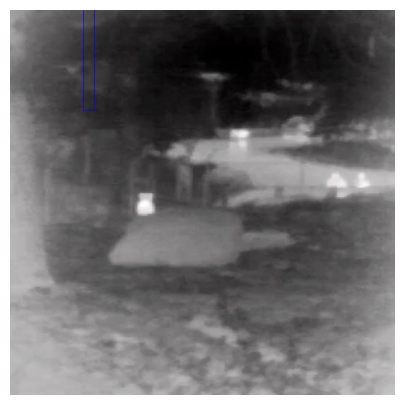

In [114]:
prediction(f"/content/drive/MyDrive/cheetah_test/PIR-206_0_mov-1_jpg.rf.e64b2e22cacf10f49ec0c48bbb526469.jpg", model)

1/1 [==============================] - 0s 26ms/step


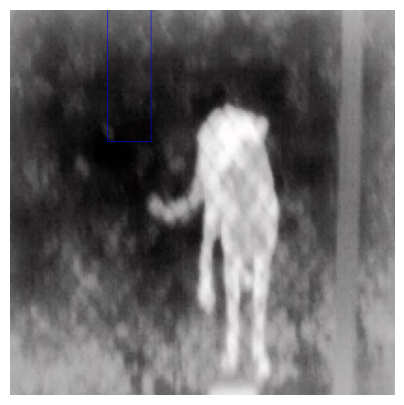

In [115]:
prediction(f"/content/drive/MyDrive/cheetah_test/PIR-206_6_mov-0_jpg.rf.fd0abacc53034d559eb5582b23dba350.jpg", model)